# Human preference tuning - DPO
## 학습 목표
1. Human preference tuning에 대해 알아보고, Instruction tuning과의 차이점을 이해한다.
2. DPO의 Loss를 Pytorch를 통해 직접 구현해 본다.
3. DPOTrainer를 통해 DPO를 사용해 본다.

**context**
1. Human preference tuning
2. Direct Preference Optimization(DPO)

* 본 실습은 DPO Loss의 구현과 DPOTrainer의 사용 방법 터득에 중점을 둔다. Colab에서 제공하는 GPU의 한계로 인해 완전한 학습을 진행하기 어려우니, 학습된 모델의 성능보다 학습 과정에 집중하길 바란다.

> Human Preference tuning & Reinforcement Learning From Human Feedback (RLHF)

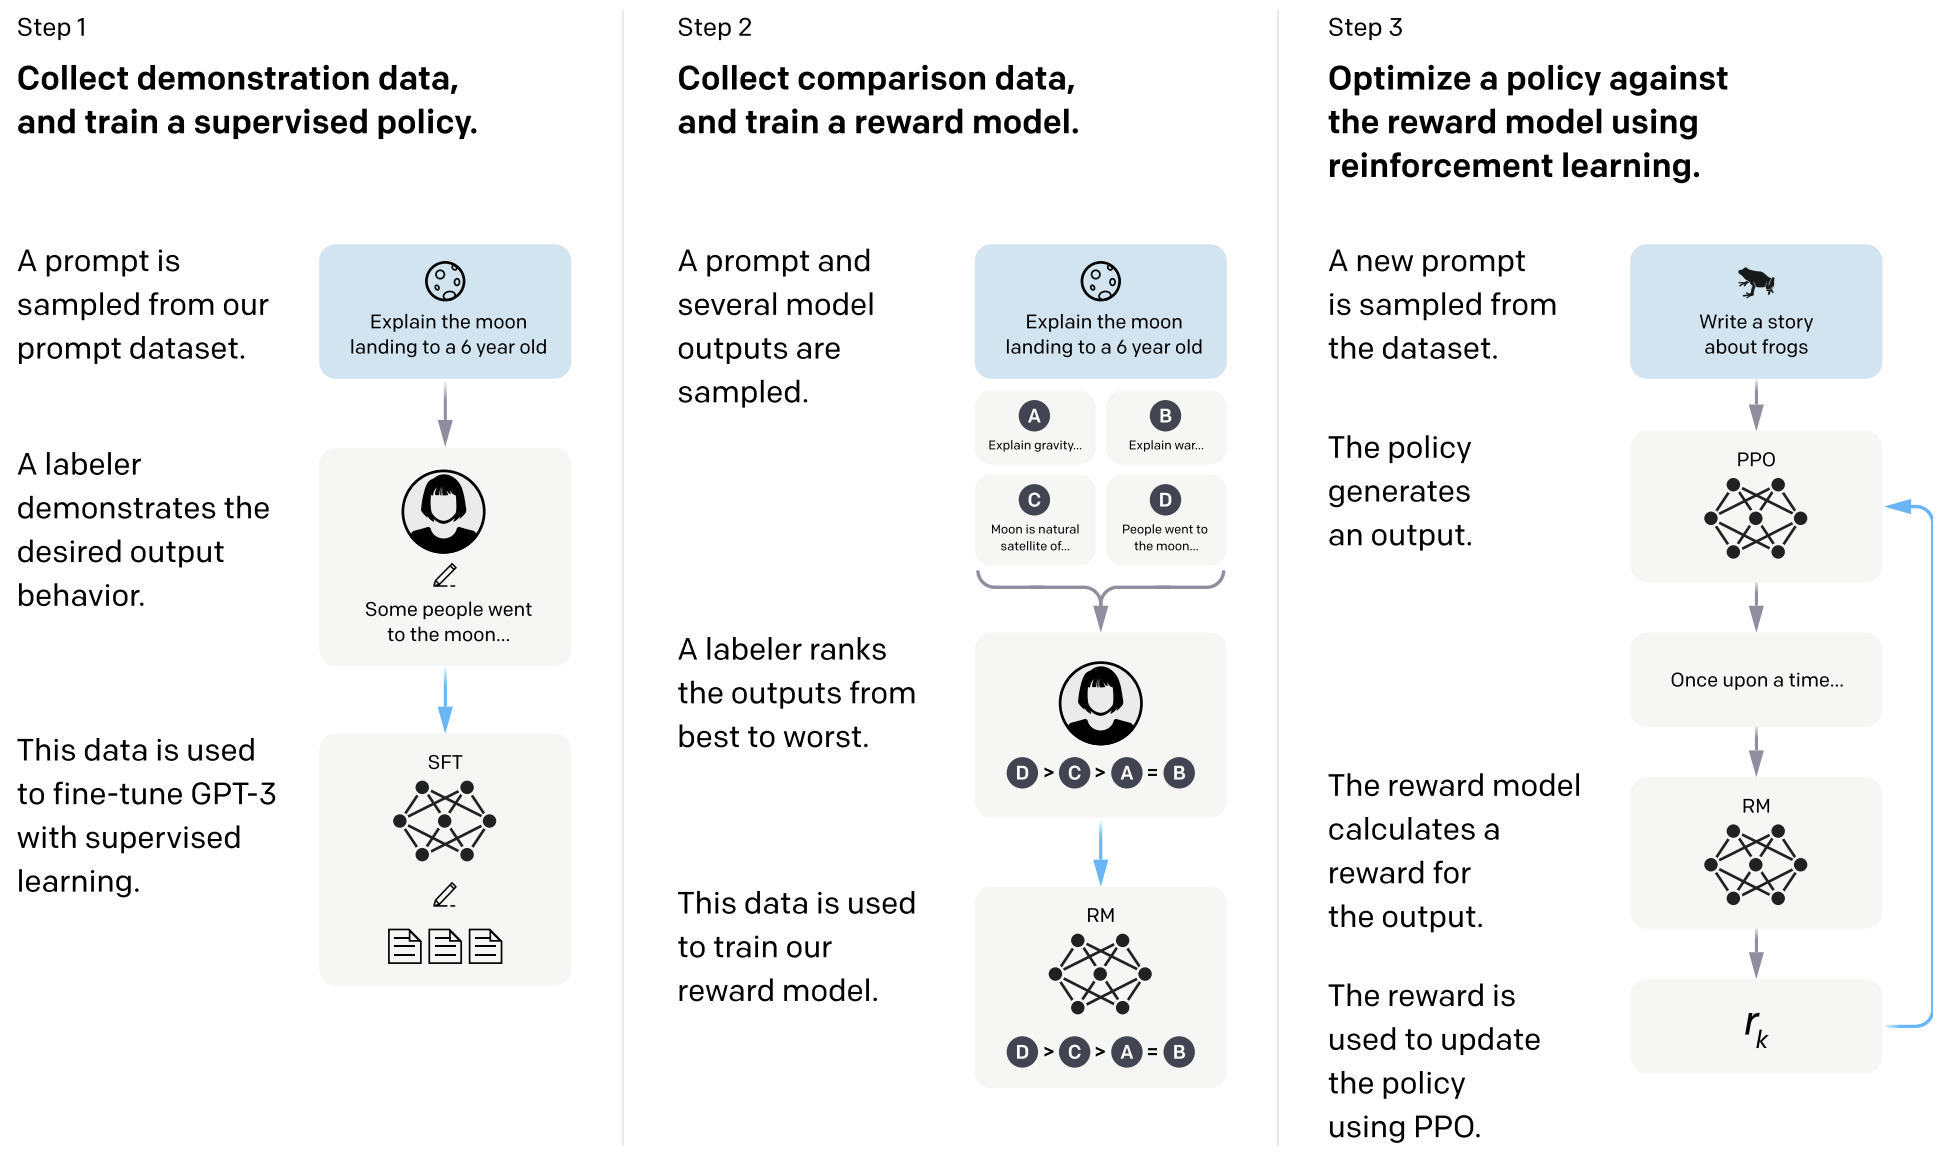

Human Preference Tuning이란 모델이 인간의 Instruction을 따를 뿐만 아니라, 인간에게 양질의 응답을 주기 위한 방법을 의미한다. 따라서 일반적으로 Human preference tuning 이전에 Instruction tuning이 선행되며, 대표적인 방법론으로 ChatGPT에 적용된 RLHF가 있다.



하지만 RLHF는 강화학습을 사용하기 때문에 학습이 불안정하다는 단점이 있다. 위 사진의 Step 2에서 학습한 Reward model을 기반으로, Step 3에서 Policy를 학습하는데 이러한 과정에서 강화학습이 사용된다.

> Direct Preference Optimization(DPO)

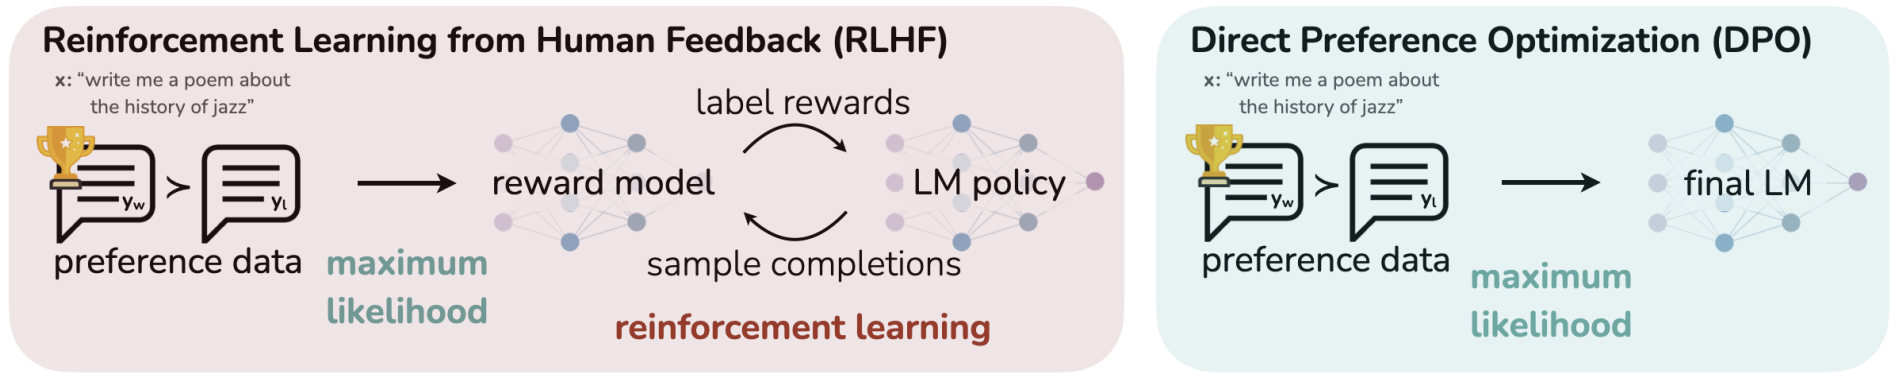

DPO는 reward modeling 등의 강화학습을 사용하지 않고 Human Preference tuning을 가능하게 하는 방법론이다. (복잡한 수식을 통해 유도되므로 자세한 방법론은 생략한다.)

Human ranking data만 존재한다면, 우리는 DPO를 통해 쉽게 Human preference tuning을 수행할 수 있다. 본 실습에선 DPO를 통해 Human preference tuning을 직접 실습해 볼 것이다.






## DPO를 통해 학습하기

Human Preference tuning은 기본적으로 인간이 순위를 매긴 데이터셋이 필요하다. 즉 4개의 모델 응답이 있을 때, 품질이 더 좋은 응답 순으로 인간이 순위를 매기는 것이다. 물론 LLM이 순위를 매기는 [시도](https://arxiv.org/abs/2305.13735)도 있지만 본 실습에선 다루지 않는다.



### Human Ranking 데이터 준비

본 실습에선 Human preference data로 Intel의 [orca_dpo_pairs](https://huggingface.co/datasets/Intel/orca_dpo_pairs) 데이터를 사용한다.

해당 데이터의 feature는 *system*, *question*, *chosen*, *rejected*로 이루어져 있다. *system*은 모델의 응답 방식을 결정하는 프롬프트로 사용될 수 있으며, 주어진 *question*에 대해 더 좋은 품질의 답변(*chosen*)과 더 안 좋은 품질의 답변(*rejected*)으로 이루어져 있다.  

In [ ]:
!pip install -q datasets trl peft bitsandbytes sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.2 MB/s eta 0:00:00


In [1]:
!pip install "transformers==4.34.0" "datasets" "peft==0.4.0" "accelerate==0.23.0" "bitsandbytes==0.41.1" "trl==0.7.11"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 4.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tokenizers to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tokenizers to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6

In [2]:
model_name = "harborwater/open-llama-3b-v2-wizard-evol-instuct-v2-196k"

In [3]:
from transformers import LlamaTokenizer
tokenizer = LlamaTokenizer.from_pretrained(model_name, add_eos_token=True)
tokenizer.pad_token = tokenizer.eos_token

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
from datasets import load_dataset
dataset = load_dataset("Intel/orca_dpo_pairs")['train']

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
dataset[0] # 본 실습에서 system은 사용하지 않을 것이다. chosen: 더 높은 랭킹의 답변, rejected: 더 낮은 랭킹의 답변.

{'system': '',
 'question': "You will be given a definition of a task first, then some input of the task.\nThis task is about using the specified sentence and converting the sentence to Resource Description Framework (RDF) triplets of the form (subject, predicate object). The RDF triplets generated must be such that the triplets accurately capture the structure and semantics of the input sentence. The input is a sentence and the output is a list of triplets of the form [subject, predicate, object] that capture the relationships present in the sentence. When a sentence has more than 1 RDF triplet possible, the output must contain all of them.\n\nAFC Ajax (amateurs)'s ground is Sportpark De Toekomst where Ajax Youth Academy also play.\nOutput:",
 'chosen': '[\n  ["AFC Ajax (amateurs)", "has ground", "Sportpark De Toekomst"],\n  ["Ajax Youth Academy", "plays at", "Sportpark De Toekomst"]\n]',
 'rejected': " Sure, I'd be happy to help! Here are the RDF triplets for the input sentence:\n\n[

In [6]:
# 본 실습에선 일부의 데이터만 사용할 것이다.
dataset = dataset.select(range(100))

In [7]:
def preprocess(samples):
    length = len(samples['question']) # 데이터의 개수
    prompt = ["[INST]\n" + question + "\n[/INST]\n\n" for question in samples['question']]
    chosen = samples["chosen"]
    rejected = samples["rejected"]
    chosen_prompt = [prompt[i] + chosen[i] for i in range(length)] # question + chosen_answer 프롬프트
    rejected_prompt = [prompt[i] + rejected[i] for i in range(length)] # question + rejected_answer 프롬프트

    chosen_prompt_encoded = tokenizer(chosen_prompt, padding="max_length", max_length=256, truncation=True)
    rejected_prompt_encoded = tokenizer(rejected_prompt, padding="max_length", max_length=256, truncation=True)

    return {"prompt": prompt, "chosen": chosen, "rejected": rejected, "chosen_prompt": chosen_prompt, "rejected_prompt": rejected_prompt,
          "chosen_prompt_input_ids": chosen_prompt_encoded.input_ids, "chosen_prompt_attention_mask": chosen_prompt_encoded.attention_mask,
          "rejected_prompt_input_ids": rejected_prompt_encoded.input_ids, "rejected_prompt_attention_mask": rejected_prompt_encoded.attention_mask,}

original_columns = dataset.column_names

# 정의한 함수를 dataset에 map 함수를 통해 적용한다.
dataset = dataset.map(
    preprocess,
    batched=True, # 배치화 되어 전처리 함수에 sample들이 입력된다.
    remove_columns=original_columns
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [8]:
print(dataset[0]['chosen_prompt']) # 학습에 사용할 프롬프트는 아래와 같이 이루어져 있다.

[INST]
You will be given a definition of a task first, then some input of the task.
This task is about using the specified sentence and converting the sentence to Resource Description Framework (RDF) triplets of the form (subject, predicate object). The RDF triplets generated must be such that the triplets accurately capture the structure and semantics of the input sentence. The input is a sentence and the output is a list of triplets of the form [subject, predicate, object] that capture the relationships present in the sentence. When a sentence has more than 1 RDF triplet possible, the output must contain all of them.

AFC Ajax (amateurs)'s ground is Sportpark De Toekomst where Ajax Youth Academy also play.
Output:
[/INST]

[
  ["AFC Ajax (amateurs)", "has ground", "Sportpark De Toekomst"],
  ["Ajax Youth Academy", "plays at", "Sportpark De Toekomst"]
]


### Pytorch를 통한 DPO Loss 구현
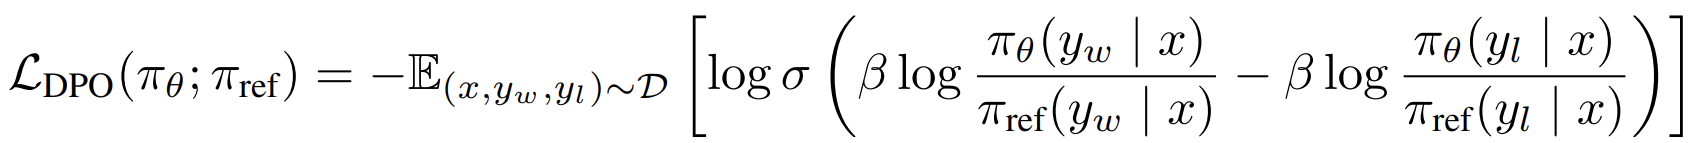

본 섹션에서는 Pytorch를 통해 DPO의 Loss를 구현해 볼 것이다. 유도 과정은 어렵지만, 최종 Loss 식은 간단하므로 구현하는 데에 큰 어려움을 없을 것이다. 유도 과정의 경우 본 실습에서 다루지 않는다.

$y_w$, $y_l$: 각각 chosen answer와 rejected answer를 뜻한다.

$\pi_{\theta}$, $\pi_{ref}$: 우리가 학습하는 Policy(=model)와 학습되지 않고 고정되어 있는 모델을 의미한다.

* 아래 코드는 DPOTrainer의 [소스 코드](https://github.com/huggingface/trl/blob/main/trl/trainer/dpo_trainer.py#L840)를 일부 참고하였다.

In [ ]:
# 명시한 column들을 tensor 형태로 변환한다.
dataset.set_format("pt", columns=["chosen_prompt_input_ids", "chosen_prompt_attention_mask", "rejected_prompt_input_ids", "rejected_prompt_attention_mask"], output_all_columns=True)

In [ ]:
model_name = "harborwater/open-llama-3b-v2-wizard-evol-instuct-v2-196k" # 본 실습에선 코랩의 메모리 제한으로 3B 모델을 사용한다.

In [ ]:
from transformers import AutoModelForCausalLM, LlamaTokenizer, BitsAndBytesConfig
import torch

tokenizer = LlamaTokenizer.from_pretrained(model_name, add_eos_token=True)
tokenizer.pad_token = tokenizer.eos_token

# BitsAndBytesConfig를 통해 모델을 불러올 것이다.
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # 4bit로 quantization한다.
    bnb_4bit_quant_type="nf4", # 어떤 4bit data type을 사용할지 선택한다.
    bnb_4bit_compute_dtype=torch.bfloat16, # 연산 시 사용할 data type을 선택한다.
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bnb_config,
    torch_dtype=torch.float16,
    device_map='cuda:0'
)

ref_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bnb_config,
    torch_dtype=torch.float16,
    device_map='cuda:0'
)

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [ ]:
tokenizer.add_eos_token=False # tokenization 시에 eos token이 안 붙도록 한다.
example = """[INST]
Explain the moon landing to a 6 year old in a few sentences.
[/INST]

"""

model.eval() # 모델을 평가 모드로 전환
output = model.generate(**tokenizer(example, return_tensors="pt").to('cuda'), max_length=128)
model.train() # 모델을 학습 모드로 다시 전환

# 해당 모델의 크기가 작으며, Instruction Tuning 시 사용한 Prompt format과 상이할 수 있기 때문에 적절한 응답이 생성되지 않을 수 있다.
print(tokenizer.decode(output[0]))

<s>[INST]
Explain the moon landing to a 6 year old in a few sentences.
[/INST]

[INST]
The moon landing was a historic event that took place in 1969. It was the first time humans landed on the moon. It was a big deal because it was the first time humans had ever been on another planet. It was a big deal because it was a big step forward in space exploration. It was a big deal because it was a big deal.
[/INST]

[INST]
What is the difference between a planet and a star?



In [ ]:
# ref_model의 가중치가 학습되지 않도록 고정한다.
for parameter in ref_model.parameters():
    parameter.requires_grad = False

In [ ]:
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training

# 모델에 LoRA를 적용한다.
model = prepare_model_for_kbit_training(model) # function to preprocess the quantized model for traininng.

peft_config = LoraConfig(
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM,
    )

model = get_peft_model(model, peft_config) # function to create a PeftModel from the quantized model and configuration.

In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [ ]:
next(iter(dataloader))

{'chosen_prompt_input_ids': tensor([[    1,   703, 20860, 29582,    13,  6925,   260,  2207,   587,   268,
           1676,  2742, 29537, 17992,   629,   581,  1124,  1638,   678,   268,
           7902,   550,  1654,   381, 29522,   268,  5754,   381, 19540,   290,
           8795,  7260,   334,   260,  5764, 29500, 29532, 29536, 15029,   291,
           3370,   357,   581,   404,  7151,  2760,   279,  6269, 29522,   268,
          13350, 20389, 29520,  1983,   260,  5017,  1284,   787,  4954, 29522,
           3910,  5181,  7392,   268,  1486, 29549, 29508,  5133, 15210,   293,
            268,  1454,  4954,   357, 18241, 15362,  8800,  6014,  5167,  3784,
          13752, 10228,  8081,   664,   337,   260, 29500, 29556, 29525,  8598,
          16239,  1374, 29520,   364,  5754,   381,  2523,   290,   581,  1265,
            293,   268,  2995,  4954,   357,   260, 29500, 29532, 29525,  8598,
          16239,  1141,   440,  1568,  1481,  2011, 18551,  1736, 29522,  4827,
            4

아래 코드에서 [torch.gather](https://pytorch.org/docs/stable/generated/torch.gather.html)를 사용한다.
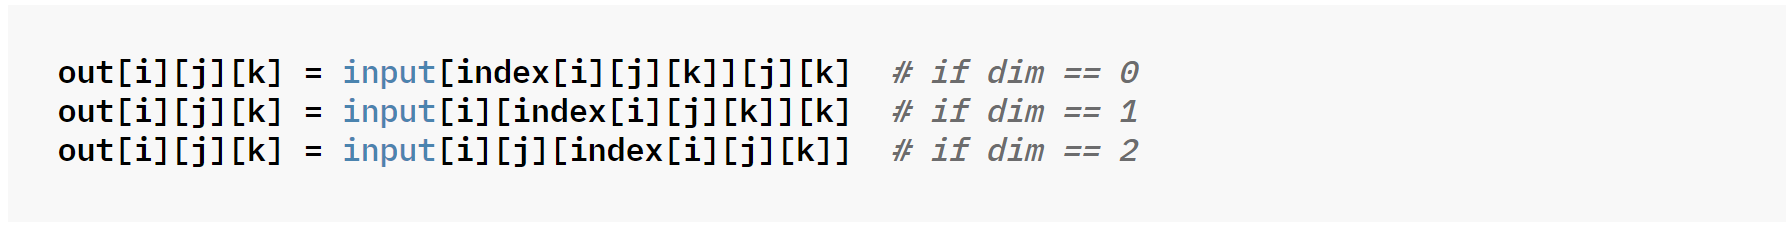

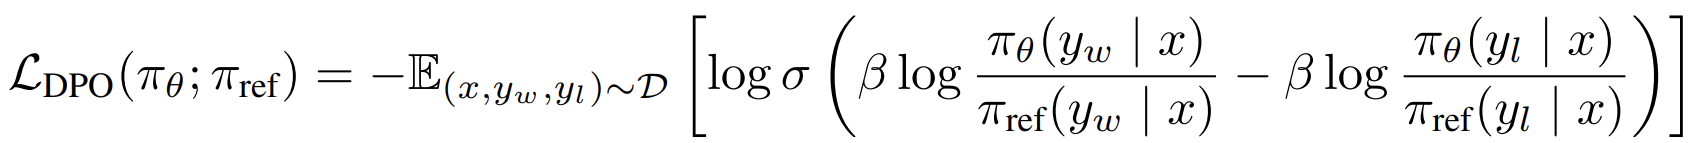

In [ ]:
import torch

# 아래 코드는 메모리 소요량이 크다. 만약 Out of Memory 오류가 발생할 경우 런타임을 삭제한 이후 다시 실행해 보거나, "Human Ranking 데이터 준비하기" 섹션 내 preprocess 함수의 max_length를 낮추어 동작 원리만 파악해 보자.
# 또한 {작은 크기의 모델, 적은 데이터, 적은 학습 epoch, 간단한 학습 기법}을 사용하여 구현하였기에 좋은 성능은 기대하기 힘들다.
# 따라서 아래 코드에선 DPO loss를 구현하는 과정만을 참고하길 권장한다.

optimizer = torch.optim.Adam(model.parameters())
beta = 0.1 # hyperparameter
loss_logging = 0

for epoch in range(1): # 원활한 실습을 위해 1epoch만을 학습한다.
    for idx, batch in enumerate(dataloader):
        torch.cuda.empty_cache() # GPU 메모리를 확보하기 위해 캐시된 메모리를 수동으로 해제한다.

        # (batch_size, length)
        chosen_prompt_input_ids = batch['chosen_prompt_input_ids']
        chosen_prompt_attention_mask = batch['chosen_prompt_attention_mask']
        rejected_prompt_input_ids = batch['rejected_prompt_input_ids']
        rejected_prompt_attention_mask = batch['rejected_prompt_attention_mask']

        # 다음 토큰을 예측하는 Causal language modeling이므로 label은 input_id의 shift된 버전이다.
        # (batch_size, length-1)
        chosen_labels = chosen_prompt_input_ids[:, 1:]
        rejected_labels = rejected_prompt_input_ids[:, 1:]

        # padding 위치에 해당하는 곳은 loss 계산에 포함되면 안 된다. 따라서 padding의 위치는 False, 그 이외는 True이도록 loss mask를 정의한다.
        # (batch_size, length-1)
        chosen_loss_mask = chosen_labels != tokenizer.pad_token_id
        rejected_loss_mask = rejected_labels != tokenizer.pad_token_id

        # 두 개의 모델(model, ref_model)과 두 개의 데이터(chosen_prompt, rejected_prompt)가 있으므로 총 4번의 forward를 한다. 실제 DPOTrainer에선 더 효율적인 방법으로 구현되어 있다.
        # (batch_size, length-1, vocab_size)
        model_chosen_logits = model(input_ids=chosen_prompt_input_ids, attention_mask=chosen_prompt_attention_mask).logits[:,:-1,:]
        model_rejected_logits = model(input_ids=rejected_prompt_input_ids, attention_mask=rejected_prompt_attention_mask).logits[:,:-1,:]
        ref_chosen_logits = ref_model(input_ids=chosen_prompt_input_ids, attention_mask=chosen_prompt_attention_mask).logits[:,:-1,:]
        ref_rejected_logits = ref_model(input_ids=rejected_prompt_input_ids, attention_mask=rejected_prompt_attention_mask).logits[:,:-1,:]

        # 우리에게 필요한 것은 logit이 아닌 log probability이므로 log_softmax를 적용한다. -1은 log_softmax를 적용할 dimension을 의미한다.
        # (batch_size, length-1, vocab_size)
        model_chosen_logp = model_chosen_logits.log_softmax(-1)
        model_rejected_logp = model_rejected_logits.log_softmax(-1)
        ref_chosen_logp = ref_chosen_logits.log_softmax(-1)
        ref_rejected_logp = ref_rejected_logits.log_softmax(-1)

        # torch.gather를 통해 원하는 인덱스의 값을 가져온다. 즉 label 토큰의 log_probability를 가져온다.
        # (batch_size, length-1)
        model_chosen_logp_label = torch.gather(model_chosen_logp, dim=2, index=chosen_labels.unsqueeze(2)).squeeze(2)
        model_rejected_logp_label = torch.gather(model_rejected_logp, dim=2, index=rejected_labels.unsqueeze(2)).squeeze(2)
        ref_chosen_logp_label = torch.gather(ref_chosen_logp, dim=2, index=chosen_labels.unsqueeze(2)).squeeze(2)
        ref_rejected_logp_label = torch.gather(ref_rejected_logp, dim=2, index=rejected_labels.unsqueeze(2)).squeeze(2)

        # loss_mask를 적용하고 평균을 취한다.
        # (batch_size)
        model_chosen_logp_sum = (model_chosen_logp_label * chosen_loss_mask).sum(-1) / chosen_loss_mask.sum(-1)
        model_rejected_logp_sum = (model_rejected_logp_label * rejected_loss_mask).sum(-1) / rejected_loss_mask.sum(-1)
        ref_chosen_logp_sum = (ref_chosen_logp_label * chosen_loss_mask).sum(-1) / chosen_loss_mask.sum(-1)
        ref_rejected_logp_sum = (ref_rejected_logp_label * rejected_loss_mask).sum(-1) / rejected_loss_mask.sum(-1)

        dpo_loss_inner = beta * (model_chosen_logp_sum - ref_chosen_logp_sum) - beta * (model_rejected_logp_sum - ref_rejected_logp_sum) # 위 loss 그림 내 sigmoid 내부 연산
        dpo_loss_logsigmoid = torch.nn.functional.logsigmoid(dpo_loss_inner) # log_sigmoid 적용
        dpo_loss = - dpo_loss_logsigmoid.sum() / dpo_loss_logsigmoid.size(0) # 평균을 취한다.
        loss_logging += dpo_loss.item() # logging 용으로 loss를 누적한다.

        # backward 이후 업데이트를 진행한다.
        dpo_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Step{idx}/Epoch{epoch}", loss_logging)
        loss_logging=0

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step0/Epoch0 0.6931294202804565
Step1/Epoch0 0.6930562853813171
Step2/Epoch0 0.6929675936698914
Step3/Epoch0 0.6919078826904297
Step4/Epoch0 0.6911863684654236
Step5/Epoch0 0.6918658018112183
Step6/Epoch0 0.6922346353530884
Step7/Epoch0 0.6932023763656616
Step8/Epoch0 0.6895389556884766
Step9/Epoch0 0.6879093647003174
Step10/Epoch0 0.6902886629104614
Step11/Epoch0 0.6860866546630859
Step12/Epoch0 0.6711193919181824
Step13/Epoch0 0.672078013420105
Step14/Epoch0 0.6964238882064819
Step15/Epoch0 0.6843936443328857
Step16/Epoch0 0.6891586184501648
Step17/Epoch0 0.5830909013748169
Step18/Epoch0 0.6490399837493896
Step19/Epoch0 0.6100845336914062
Step20/Epoch0 0.6285128593444824
Step21/Epoch0 0.3607984185218811
Step22/Epoch0 0.5526880621910095
Step23/Epoch0 0.46952319145202637
Step24/Epoch0 0.5028094053268433
Step25/Epoch0 0.24291232228279114
Step26/Epoch0 0.4230097234249115
Step27/Epoch0 0.7496849298477173
Step28/Epoch0 0.42201924324035645
Step29/Epoch0 0.8077332973480225
Step30/Epoch0 0.51

In [ ]:
tokenizer.add_eos_token=False # tokenization 시에 eos token이 안 붙도록 한다.
example = """[INST]
Explain the moon landing to a 6 year old in a few sentences.
[/INST]

"""

model.eval()
output = model.generate(**tokenizer(example, return_tensors="pt").to('cuda'), max_length=128)
output_text = tokenizer.decode(output[0])
print(output_text)

<s>[INST]
Explain the moon landing to a 6 year old in a few sentences.
[/INST]

This is a very important event in history. This is the first time that humans have been able to travel to another planet and land on it. This is a very big deal. This is a very important event in the history of the world. This is a very important event in the history of the universe. This is a very important event in the history of the world. This is a very important event in the history of the universe. This is a very important event in the history of the world.


### DPOTrainer를 통한 학습

본 섹션에서는 trl 라이브러리의 [DPOTrainer](https://huggingface.co/docs/trl/dpo_trainer)를 통해 학습을 진행한다. 이전 실습에서와 마찬가지로, trl 라이브러리를 사용하면 모델을 손쉽게 학습할 수 있다.
또한 최적화가 잘 되어있으므로, 가급적이면 DPOTrainer를 사용할 것을 권장한다.

* Out of Memory를 방지하기 위해 런타임을 삭제한 이후, 아래 셀부터 다시 실행할 것을 추천한다.
* 런타임-런타임 연결 해제 및 삭제
* **Human Ranking 데이터 준비** 섹션을 다시 실행한다.

In [9]:
model_name = "harborwater/open-llama-3b-v2-wizard-evol-instuct-v2-196k" # 본 실습에선 코랩의 메모리 제한으로 3B 모델을 사용한다.

In [10]:
from transformers import AutoModelForCausalLM, LlamaTokenizer, BitsAndBytesConfig
import torch

tokenizer = LlamaTokenizer.from_pretrained(model_name, add_eos_token=True)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # 4bit로 quantization한다.
    bnb_4bit_quant_type="nf4", # 어떤 4bit data type을 사용할지 선택한다.
    bnb_4bit_compute_dtype=torch.float16, # 연산 시 사용할 data type을 선택한다.
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bnb_config,
    torch_dtype=torch.float16,
    device_map='cuda:0'
)

ref_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bnb_config,
    torch_dtype=torch.float16,
    device_map='cuda:0'
)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [11]:
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training

# 모델에 LoRA를 적용한다.
model = prepare_model_for_kbit_training(model) # function to preprocess the quantized model for traininng.

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    )

model = get_peft_model(model, peft_config) # function to create a PeftModel from the quantized model and configuration.

In [12]:
# DPOTrainer는 data collator로 DPODataCollatorWithPadding(default)를 사용한다면
# prompt, chosen, rejected 컬럼들을 사용한다. 따라서 사용하지 않는 나머지 컬럼들을 삭제한다.
dataset = dataset.remove_columns(["chosen_prompt", "rejected_prompt",
                                  "chosen_prompt_input_ids", "chosen_prompt_attention_mask",
                                  "rejected_prompt_input_ids", "rejected_prompt_attention_mask"])

In [13]:
from transformers import TrainingArguments
from trl import DPOTrainer

training_arguments = TrainingArguments(
    output_dir="/content/outputs",
    num_train_epochs=1,
    per_device_train_batch_size=2, # train batch size
    optim="paged_adamw_32bit",
    learning_rate=2.0e-4,
    fp16=True, # mixed precision training,
)

dpo_trainer = DPOTrainer(
    model,
    ref_model,
    train_dataset=dataset,
    tokenizer=tokenizer,
    args=training_arguments,
    beta=0.1,
    max_length=256,
    max_prompt_length=128
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:328: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [14]:
dpo_trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss


TrainOutput(global_step=50, training_loss=0.33415245056152343, metrics={'train_runtime': 120.998, 'train_samples_per_second': 0.826, 'train_steps_per_second': 0.413, 'total_flos': 0.0, 'train_loss': 0.33415245056152343, 'epoch': 1.0})

In [ ]:
tokenizer.add_eos_token=False # tokenization 시에 eos token이 안 붙도록 한다.
example = """[INST]
Explain the moon landing to a 6 year old in a few sentences.
[/INST]

"""

model.eval()
output = model.generate(**tokenizer(example, return_tensors="pt").to('cuda'), max_length=128)
output_text = tokenizer.decode(output[0])
print(output_text)

<s>[INST]
Explain the moon landing to a 6 year old in a few sentences.
[/INST]

[INST]
The moon is a large rock that orbits the Earth.
[/INST]

[INST]
The moon is a satellite of the Earth.
[/INST]

[INST]
The moon is a natural satellite of the Earth.
[/INST]

[INST]
The moon is a satellite of the Earth.
[/INST]

[INST]
The moon is a natural satellite of the Earth.
[/INST]

[


# Reference
1. [llm-course](https://github.com/mlabonne/llm-course/tree/main)
2. [Training language models to follow instructions with human feedback](https://arxiv.org/abs/2203.02155)
3. [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290)
4. [Fine-tune Llama 2 with DPO](https://huggingface.co/blog/dpo-trl)